In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Mi pc no aguanta apriori :<, pruebo con mlxtend
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, fpmax
import fim

In [24]:
df = pd.read_csv('./data/cleaned_online_retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [25]:
#A lo largo del tiempo vemos dos variaciones por cada mitad del año, por eso creo que separarlo en mitad tiene sentido sin complicar las cosas demas
# Creo que obtendremos mejores resultados porque estamos comparando dos periodos con cambios muy marcados por la etapa del a;o.
part1 = df[df['InvoiceDate'] < '2011-06-01']
part2 = df[df['InvoiceDate'] >= '2011-06-01']

In [26]:
def patternMining(df_oh, min_support, nd, transactions):
    freq = fpgrowth(df_oh, min_support=min_support, use_colnames=True)
    print("Itemsets frecuentes de la particion numero", nd)
    print(freq.head())
    rules = association_rules(freq, metric="lift", min_threshold=1)
    print("Reglas de asociacion de la particion numero", nd)
    print(rules[['support', 'confidence', 'lift']].head())
    maximal = fpmax(df_oh, min_support=min_support, use_colnames=True)
    print("Maximales de la particion numero", nd)
    print(maximal.head())

    supp_count = int(min_support * len(transactions))
    
    closed = fim.fpgrowth(transactions, supp = supp_count , target = "c", report = "aS")
    print("Closed itemsets de la particion ", nd)
    print(closed)
    return freq, rules, maximal, closed

In [27]:
transactions1 = part1.groupby('InvoiceNo')['Description'].apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions1).transform(transactions1)
oneHot1 = pd.DataFrame(te_ary, columns=te.columns_)

transactions2 = part2.groupby('InvoiceNo')['Description'].apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions2).transform(transactions2)
oneHot2 = pd.DataFrame(te_ary, columns=te.columns_)


In [28]:
fre1, rules1, max1, closed1 = patternMining(oneHot1, 0.01, 1, transactions1)
fre2, rules2, max2 , closed2= patternMining(oneHot2, 0.01, 2, transactions2)

Itemsets frecuentes de la particion numero 1
    support                               itemsets
0  0.112946   (WHITE HANGING HEART T-LIGHT HOLDER)
1  0.022972  (KNITTED UNION FLAG HOT WATER BOTTLE)
2  0.020699       (CREAM CUPID HEARTS COAT HANGER)
3  0.019981                  (WHITE METAL LANTERN)
4  0.017229       (RED WOOLLY HOTTIE WHITE HEART.)
Reglas de asociacion de la particion numero 1
    support  confidence       lift
0  0.012443    0.110169   2.495384
1  0.012443    0.281843   2.495384
2  0.017349    0.392954  11.247633
3  0.017349    0.496575  11.247633
4  0.010529    0.093220   2.668273
Maximales de la particion numero 1
   support                            itemsets
0  0.01005   (UNION JACK FLAG PASSPORT COVER )
1  0.01005    (FELTCRAFT PRINCESS OLIVIA DOLL)
2  0.01005  (HANGING WOOD AND FELT BUTTERFLY )
3  0.01005     (12 PENCILS TALL TUBE WOODLAND)
4  0.01005        (RECYCLED ACAPULCO MAT PINK)
Closed itemsets de la particion  1
[]
Itemsets frecuentes de la particion nu

In [29]:
#support2 / support1

#df completo
merged_df = pd.merge(fre1, fre2, on='itemsets', how='outer', suffixes=('_1', '_2')).fillna(0)

#en los infinitos hay un JEP. Es la matrica que mas nos dice algo, especialmente considerando que estamos 
# evaluado etapas del a;o
merged_df['growth_rate'] = np.where(
    merged_df['support_1'] == 0, 
    np.inf, 
    merged_df['support_2'] / merged_df['support_1']
)

#emerging patterns si el GR > 1. Quitamos los inf porque son JEPs
eps = merged_df[(merged_df['growth_rate'] > 1) & (merged_df['growth_rate'] != np.inf)]
eps = eps.sort_values(by='growth_rate', ascending=False)

jeps = merged_df[merged_df['growth_rate'] == np.inf]
jeps = jeps.sort_values(by='support_2', ascending=False)


print("Emerging Patterns encontrados: " , len(eps))
print("Top Emerging Patterns:")
print(eps[['itemsets', 'support_1', 'support_2', 'growth_rate']].head())

print("Jumping Emerging Patterns encontrados: ", len(jeps))
print("Top Jumping Emerging Patterns:")
print(jeps[['itemsets', 'support_2', 'growth_rate']].head())

Emerging Patterns encontrados:  336
Top Emerging Patterns:
                                   itemsets  support_1  support_2  growth_rate
2130               (JUMBO BAG VINTAGE LEAF)   0.012324   0.059972     4.866456
1494               (HAND WARMER OWL DESIGN)   0.010888   0.041112     3.775957
1564      (PAPER CHAIN KIT 50'S CHRISTMAS )   0.019263   0.066672     3.461156
1606    (PAPER CHAIN KIT VINTAGE CHRISTMAS)   0.015315   0.047729     3.116577
1611  (SET OF 20 VINTAGE CHRISTMAS NAPKINS)   0.011606   0.035239     3.036336
Jumping Emerging Patterns encontrados:  1055
Top Jumping Emerging Patterns:
                                 itemsets  support_2  growth_rate
324   (GARDENERS KNEELING PAD KEEP CALM )   0.064439          inf
538          (SET OF 3 REGENCY CAKE TINS)   0.060303          inf
133          (HOT WATER BOTTLE KEEP CALM)   0.054843          inf
127            (JUMBO BAG VINTAGE DOILY )   0.054761          inf
343  (GARDENERS KNEELING PAD CUP OF TEA )   0.054430         

Se pueden identificar cosas interesantes y coherentes considerando la particion. Articulos navide;os como PAPER CHAIN KIT 50'S CHRISTMAS y demas han triplicado su presencia. Esto luego se vera mejor en graficas; esto nos podria indicar las fechas idoneas para empezar a promocionar estos productos. Ademas, tenemos un HAND WARMER OWL DESIGN por ejemplo, que nos indica el cambio de temporada; de igual manera, identificar en que fecha exactamente se produce su cambio para poder saber cuando promocionarlo; esto puede variar cada a;o debido a feonomenos meteorologicos. 

En cuanto a los JEps, estos nos indican mas que todo tendencias o modas virales; especialmente considerando que el dataset es del a;o 2011, cuando las redes sociales crecieron en popularidad. 

Creo que podemos concluir que el dataset nos habla mucho acerca del ciclo estacional y tendencias muy marcadas y su relacion con el negocio propuesto 

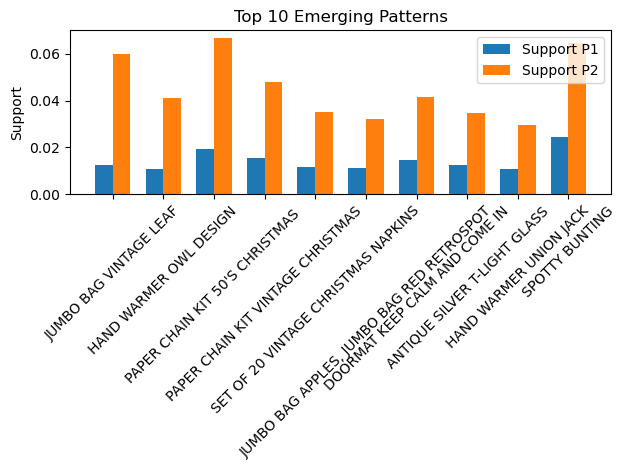

In [30]:
def iset_to_str(s):
    try:
        return ', '.join(sorted(s))
    except:
        return str(s)

top_eps = eps.head(10).copy()
top_eps['item'] = top_eps['itemsets'].apply(iset_to_str)


x = np.arange(len(top_eps))
width = 0.35
plt.bar(x - width/2, top_eps['support_1'], width, label='Support P1')
plt.bar(x + width/2, top_eps['support_2'], width, label='Support P2')
plt.xticks(x, top_eps['item'], rotation=45)
plt.ylabel('Support')
plt.title('Top 10 Emerging Patterns')
plt.legend()
plt.tight_layout()
plt.show()

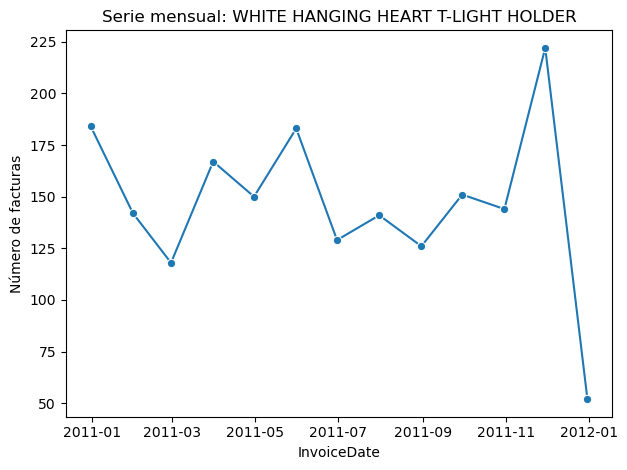

In [31]:
product = "WHITE HANGING HEART T-LIGHT HOLDER"  

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
ts = (df[df['Description'].str.strip() == product.strip()]
      .set_index('InvoiceDate')
      .resample('ME')['InvoiceNo']
      .nunique()) 

sns.lineplot(x=ts.index, y=ts.values, marker='o')
plt.title(f'Serie mensual: {product.strip()}')
plt.ylabel('Número de facturas')
plt.tight_layout()
plt.show()

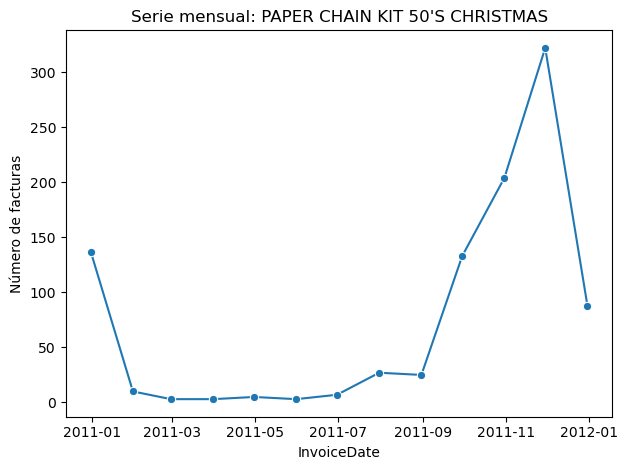

In [32]:
product = "PAPER CHAIN KIT 50'S CHRISTMAS"  

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
ts = (df[df['Description'].str.strip() == product.strip()]
      .set_index('InvoiceDate')
      .resample('ME')['InvoiceNo']
      .nunique()) 

sns.lineplot(x=ts.index, y=ts.values, marker='o')
plt.title(f'Serie mensual: {product.strip()}')
plt.ylabel('Número de facturas')
plt.tight_layout()
plt.show()

In [33]:
#GR entre 0.8 y 1.2 -> patron estable
stable = merged_df[(merged_df['growth_rate'] >= 0.8) & (merged_df['growth_rate'] <= 1.2)]
stable = stable.sort_values(by='support_2', ascending=False)

#GR menor a 0.8 -> patron decreciente
declining = merged_df[(merged_df['growth_rate'] < 0.8) & (merged_df['support_2'] > 0)]
declining = declining.sort_values(by='growth_rate', ascending=True)

#GR mayor a 1.2 -> patron incrementante
incrementing = merged_df[(merged_df['growth_rate'] > 1.2) & (merged_df['growth_rate'] != np.inf)]
incrementing = incrementing.sort_values(by='growth_rate', ascending=False)

print("Patrones Estables encontrados: ", len(stable))
print("Top Patrones Estables:")
print(stable[['itemsets', 'support_1', 'support_2', 'growth_rate']].head())

print("Patrones Decrecientes encontrados: ", len(declining))
print("Top Patrones Decrecientes:")
print(declining[['itemsets', 'support_1', 'support_2', 'growth_rate']].head())

print("Patrones Incrementantes encontrados: ", len(incrementing))
print("Top Patrones Incrementantes:")
print(incrementing[['itemsets', 'support_1', 'support_2', 'growth_rate']].head())

Patrones Estables encontrados:  375
Top Patrones Estables:
                                 itemsets  support_1  support_2  growth_rate
512             (JUMBO BAG RED RETROSPOT)   0.087222   0.091405     1.047965
1522            (LUNCH BAG RED RETROSPOT)   0.072745   0.071056     0.976791
1305                      (PARTY BUNTING)   0.070830   0.059227     0.836187
1489                (LUNCH BAG CARS BLUE)   0.049653   0.057904     1.166170
2116  (SET OF 3 CAKE TINS PANTRY DESIGN )   0.060062   0.056332     0.937898
Patrones Decrecientes encontrados:  184
Top Patrones Decrecientes:
                                 itemsets  support_1  support_2  growth_rate
2115  (SET OF 6 SPICE TINS PANTRY DESIGN)   0.065327   0.021011     0.321627
1508    (CANDLEHOLDER PINK HANGING HEART)   0.029553   0.011415     0.386273
1108       (PLEASE ONE PERSON METAL SIGN)   0.054319   0.023327     0.429443
1719           (FELTCRAFT CUSHION RABBIT)   0.026681   0.011746     0.440246
1498      (LADIES & GENTLEM

Para entender lo que significa para el negocio y encontrar cosas relevantes se debe entender que al ofrecer una gran variedad de productos, es complicado entender que identifica a la tienda en si. Considerando eso y que entre los productos crecientes tenemos productos relacionados a lo estacional, creemos que el negocio debe adaptar su gran catalogo de productos mas que nada a modas y temporadas sin dejar de lago los productos estables como las mochilas. 

En conclusión, el negocio parece sostenerse en los artículos utilitarios de siempre, pero la verdadera oportunidad de ganancia está en la forma en que se pueden adaptar al momento y contexto que indica el año.